# 월마트 날씨별 판매량 예측

> ### 지점-아이템-날짜 기준으로 판매량(unit) 예측!

> - 일단 test.csv파일에 나와있는 항목들만 예측하도록 한다.

> - 학습은 train.csv파일에 있는 항목으로 진행한다.

> - output 형식은 sampleSubmission.csv파일의 내용을 참고한다
    - id, units = "2_1_2013-04-01" , int


In [ ]:
#주피터노트북 그래프설정

%matplotlib inline
#주피터노트북에서 라인 아래에 보여지도록 설정

%config InlineBackend.figure_formats = {'png','retina'} 
#png 이미지 압축기술설정, retina 그래프 해상도 2배 높히기

#그래프 한글폰트 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

#그래프 한글폰트 설정
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgunbd.ttf").get_name()
rc('font', family=font_name)
#음수처리
mpl.rcParams['axes.unicode_minus'] = False

In [4]:
import os
import numpy as np
import pandas as pd
import pandas_profiling as pdp

In [5]:
#전체기후날씨데이터(weather.csv) 불러오기
weather = pd.read_csv('weather.csv')
# weather["date"]=weather["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
#지점-기후관측소 대조표(key.csv) 불러오기
map_key = pd.read_csv('key.csv')

#일일-지점-상품-판매량 정보(train.csv) 불러오기
store_data = pd.read_csv('train.csv')

#판매량 예측을 위한 지점정보(test.csv) 불러오기
test = pd.read_csv('test.csv')

In [6]:
#전체데이터 조합
    #1. store_data에 스테이션 넘버 부여
result_df = store_data.merge(map_key, left_on="store_nbr", right_on="store_nbr" )
cols = ['date', 'store_nbr', 'station_nbr', 'item_nbr', 'units']
new_df = result_df[cols] #열 위치변경된 것들

    #2. 종합세팅
all_set = new_df.merge(weather, left_on=["date","station_nbr"], right_on=["date","station_nbr"] )


In [7]:
# 데이터타입 날짜화 및 int화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
all_set["date"]=all_set["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
all_set["avgspeed"] = pd.to_numeric(all_set["avgspeed"], errors='coerce')
all_set["tavg"] = pd.to_numeric(all_set["tavg"], errors='coerce')
all_set["dewpoint"] = pd.to_numeric(all_set["dewpoint"], errors='coerce')
all_set["snowfall"] = pd.to_numeric(all_set["snowfall"], errors='coerce')
all_set["preciptotal"] = pd.to_numeric(all_set["preciptotal"], errors='coerce')

In [8]:
all_set["tmax"] = pd.to_numeric(all_set["tmax"], errors='coerce')
all_set["tmin"] = pd.to_numeric(all_set["tmin"], errors='coerce')

In [9]:
all_set.dtypes

date           datetime64[ns]
store_nbr               int64
station_nbr             int64
item_nbr                int64
units                   int64
tmax                  float64
tmin                  float64
tavg                  float64
depart                 object
dewpoint              float64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
snowfall              float64
preciptotal           float64
stnpressure            object
sealevel               object
resultspeed            object
resultdir              object
avgspeed              float64
dtype: object

In [80]:
# all_set.head()
all_set.iloc[::140,16]

0          36.0
140        26.0
280         4.0
420        -1.0
560        21.0
700        28.0
840        22.0
980        12.0
1120       21.0
1260       31.0
1400       27.0
1540       12.0
1680        3.0
1820       34.0
1960       15.0
2100       11.0
2240        9.0
2380       12.0
2520       30.0
2660       39.0
2800       23.0
2940       36.0
3080       27.0
3220       15.0
3360       26.0
3500       33.0
3640       26.0
3780       16.0
3920        8.0
4060       18.0
           ... 
4613420    50.0
4613560    51.0
4613700    50.0
4613840    60.0
4613980    58.0
4614120    54.0
4614260    55.0
4614400    49.0
4614540    57.0
4614680    40.0
4614820    42.0
4614960    52.0
4615100    37.0
4615240    37.0
4615380     NaN
4615520    47.0
4615660    60.0
4615800    64.0
4615940    55.0
4616080    55.0
4616220    35.0
4616360    31.0
4616500    50.0
4616640    50.0
4616780    45.0
4616920    42.0
4617060    38.0
4617200    47.0
4617340    55.0
4617480    38.0
Name: snowfall, Length: 

---
# 날씨분석용 함수-------------------------

In [11]:
#날씨테이블만 정리-도출하는 함수 제작-----------------------------------
#----1.기간-스테이션별 요소값 df도출 함수
#----2.기간-평균값 df도출 함수

#-------특정 날씨요소값의 날짜-관측소 데이터 도출함수
def weather_pivot(column_name):

    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])

        # 스테이션별 피봇팅(테이블)
    station_value = station_itm.pivot("date","station_nbr",column_name)
    station_table = station_value.apply(pd.to_numeric, errors = 'coerce')

    return station_table
    

#--------날짜별 (숫자형)날씨요소 평균 도출함수---------
def weather_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["date","station_nbr",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M","T","  T",None],np.NaN) #--특정문자 NaN으로 변환
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    avg_df = station_itm.pivot_table(column_name,["date"], aggfunc=np.mean)
    avg_df = avg_df.apply(pd.to_numeric, errors = 'ignore')

    return avg_df


#--------스테이션-전체날짜 날씨요소평균 도출함수---------
def station_mean(column_name):
    station_itm = pd.DataFrame(weather,columns=["station_nbr","date",column_name])
        # 데이터타입 숫자화(이거 안되면 에러나니까 꼭 타입정제부터 하자)
    temp_df = station_itm.replace(["M","T","  T",None],np.NaN) #--특정문자 NaN으로 변환
    station_itm = temp_df.apply(pd.to_numeric, errors = 'ignore')
        # 평균구해넣기
    station_avg = station_itm.pivot_table(column_name,["station_nbr"], aggfunc=np.mean)
    station_avg = station_avg.apply(pd.to_numeric, errors = 'ignore')
    
    return station_avg



#=============================================================================

#지점별 avgspeed테이블 만들기 + mean speed 행 만들기--------------------------------
# station_wth = pd.DataFrame(weather,columns=["station_nbr","date","avgspeed"])


# station_speed = station_wth.pivot("date","station_nbr","avgspeed")
# station_speed = station_speed.replace(["M",None],0)

# station_speed = station_speed.astype(int, errors='ignore')



#----------이제 함수를 써보자!

#1. 이슬점온도
station_dewpoint = weather_pivot("dewpoint")
station_dewpoint_avg = weather_mean("dewpoint")

#2. 하루평균온도
station_temp = weather_pivot("tavg")
station_temp_avg = weather_mean("tavg")

#3. 하루평균 바람세기
station_speed = weather_pivot("avgspeed")
station_speed_avg = weather_mean("avgspeed")
station_speed_eachavg = station_mean("avgspeed")

#4. 기압도
station_pressure = weather_pivot("stnpressure")
station_pressure_avg = weather_mean("stnpressure")
station_pressure_eachavg = station_mean("stnpressure") #개별 스테이션별 평균 기압

#5. 이상기후온도
station_depart = weather_pivot("depart")
station_depart_avg = weather_mean("depart")

#6. 적셜량
station_snow = weather_pivot("snowfall")
station_snow_avg = weather_mean("snowfall")
station_snow_eachavg = station_mean("snowfall") #개별 스테이션별 평균 적설량

#7. 강우량
station_rain = weather_pivot("preciptotal")
station_rain_avg = weather_mean("preciptotal")
station_rain_eachavg = station_mean("preciptotal") #개별 스테이션별 평균 적설량

#8. 바람방향
station_dir = weather_pivot("resultdir")
station_dir_avg = weather_mean("resultdir")
station_dir_eachavg = station_mean("resultdir")
                           

In [15]:
#결과값 테스트창-----------------------------------------------------------------------
# weather
# station_dewpoint
# station_dewpoint_avg
# station_temp
station_speed.describe()
# station_rain_eachavg.describe()
# np.average(station_depart_avg["depart"])

# plt.figure(figsize=(12,8))

# X = range(len(station_rain_avg["preciptotal"]))
# Y = station_rain_avg["preciptotal"]

# plt.bar(X,Y)
# plt.show()

station_nbr,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,1032.000000,1031.000000,1033.000000,1033.000000,30.000000,1033.000000,1032.000000,1030.000000,1030.000000,1034.000000,1032.000000,1033.000000,1034.000000,1033.000000,1032.000000,1027.000000,1034.000000,1033.000000,1033.000000,1033.000000
mean,6.572190,9.721435,9.544240,5.141433,10.043333,7.928848,11.814438,5.444660,8.267087,8.401741,6.327422,6.376573,7.905319,11.173959,5.327422,7.354528,6.265474,9.434366,9.310358,7.987803
std,3.261478,3.633487,4.097332,2.231389,2.729113,3.674694,4.863789,3.034551,3.725323,3.009192,2.812242,2.848761,2.930552,4.383771,3.367384,3.295210,3.150085,3.881684,3.498729,3.088583
min,0.600000,1.700000,1.600000,0.500000,4.800000,0.800000,1.000000,0.000000,0.900000,2.300000,1.200000,1.200000,0.700000,2.400000,0.100000,0.500000,0.100000,1.200000,2.200000,1.100000
25%,4.200000,7.000000,6.500000,3.500000,8.300000,5.200000,8.000000,3.100000,5.500000,6.400000,4.300000,4.400000,6.000000,7.700000,2.900000,5.100000,3.900000,6.500000,6.800000,5.800000
50%,6.100000,9.300000,8.900000,4.800000,9.700000,7.300000,11.000000,4.900000,7.700000,7.850000,5.800000,5.800000,7.300000,10.500000,4.500000,6.800000,5.800000,9.000000,9.000000,7.500000
75%,8.200000,11.850000,12.300000,6.700000,11.750000,10.200000,15.100000,7.400000,10.500000,9.900000,7.900000,8.000000,9.200000,14.200000,7.100000,9.000000,8.100000,12.000000,11.600000,9.800000
max,19.800000,23.600000,22.600000,12.800000,16.000000,19.400000,28.700000,16.200000,22.500000,21.900000,17.400000,16.600000,22.900000,26.100000,21.900000,23.400000,17.300000,20.800000,24.800000,20.900000


In [15]:
weather

,station_nbr,date,tmax,tmin,tavg,depart,dewpoint,wetbulb,heat,cool,sunrise,sunset,codesum,snowfall,preciptotal,stnpressure,sealevel,resultspeed,resultdir,avgspeed
0,1,2012-01-01,52,31,42,M,36,40,23,0,-,-,RA FZFG BR,M,0.05,29.78,29.92,3.6,20,4.6
1,2,2012-01-01,48,33,41,16,37,39,24,0,0716,1626,RA,0.0,0.07,28.82,29.91,9.1,23,11.3
2,3,2012-01-01,55,34,45,9,24,36,20,0,0735,1720,,0.0,0.00,29.77,30.47,9.9,31,10.0
3,4,2012-01-01,63,47,55,4,28,43,10,0,0728,1742,,0.0,0.00,29.79,30.48,8.0,35,8.2
4,6,2012-01-01,63,34,49,0,31,43,16,0,0727,1742,,0.0,0.00,29.95,30.47,14.0,36,13.8
5,7,2012-01-01,50,33,42,M,26,35,23,0,-,-,,0.0,0.00,29.15,30.54,10.3,32,10.2
6,8,2012-01-01,66,45,M,M,34,46,M,M,-,-,RA BR,M,0.00,30.05,M,11.0,36,10.9
7,9,2012-01-01,34,19,27,M,17,23,38,0,-,-,UP,M,T,29.34,30.09,22.8,30,22.5
8,10,2012-01-01,73,53,63,M,55,58,2,0,0723,1738,FG+ FG BR,M,0.00,30.16,30.19,5.1,24,5.5
9,11,2012-01-01,72,48,60,7,54,56,5,0,0724,1737,FG+ FG BR,0.0,0.00,30.15,30.18,4.6,23,4.8


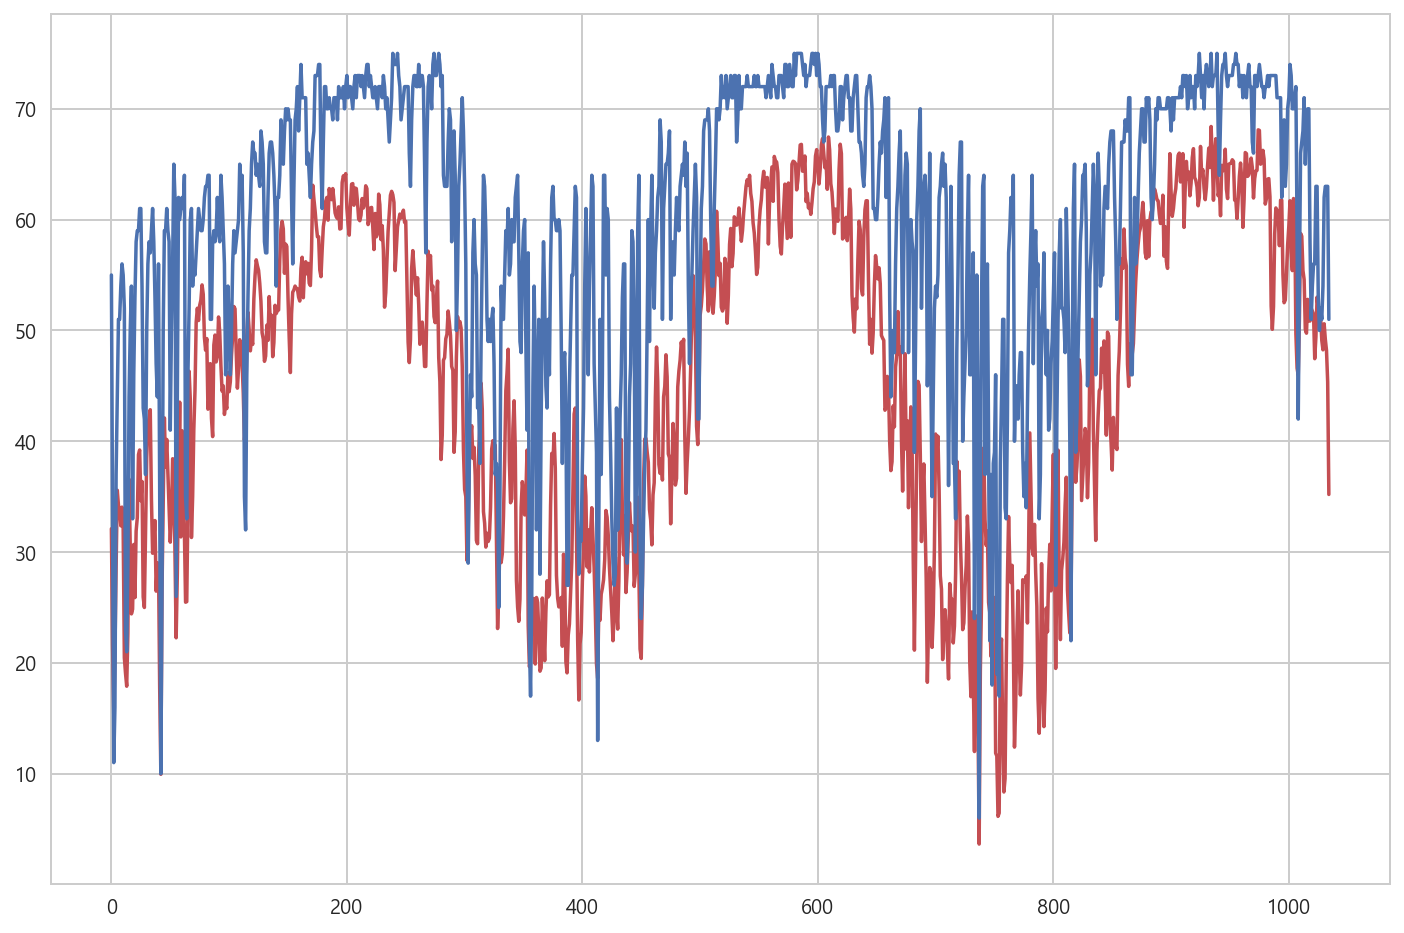

In [55]:
# plotchart - 날짜별 날씨요소 비교 시각화

plt.figure(figsize=(12,8))

#개별데이터
# y1 = station_heat[1]
# y2 = station_heat[18]
# y3 = station_heat[20]

#전체평균온도
Ya = station_dewpoint[10]
Y_dew = station_dewpoint_avg["dewpoint"]

plt.plot(range(len(Y_dew)),Y_dew, "r", range(len(Ya)),Ya, "b")
# plt.yticks([0,10,20,30,40,50,60])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()

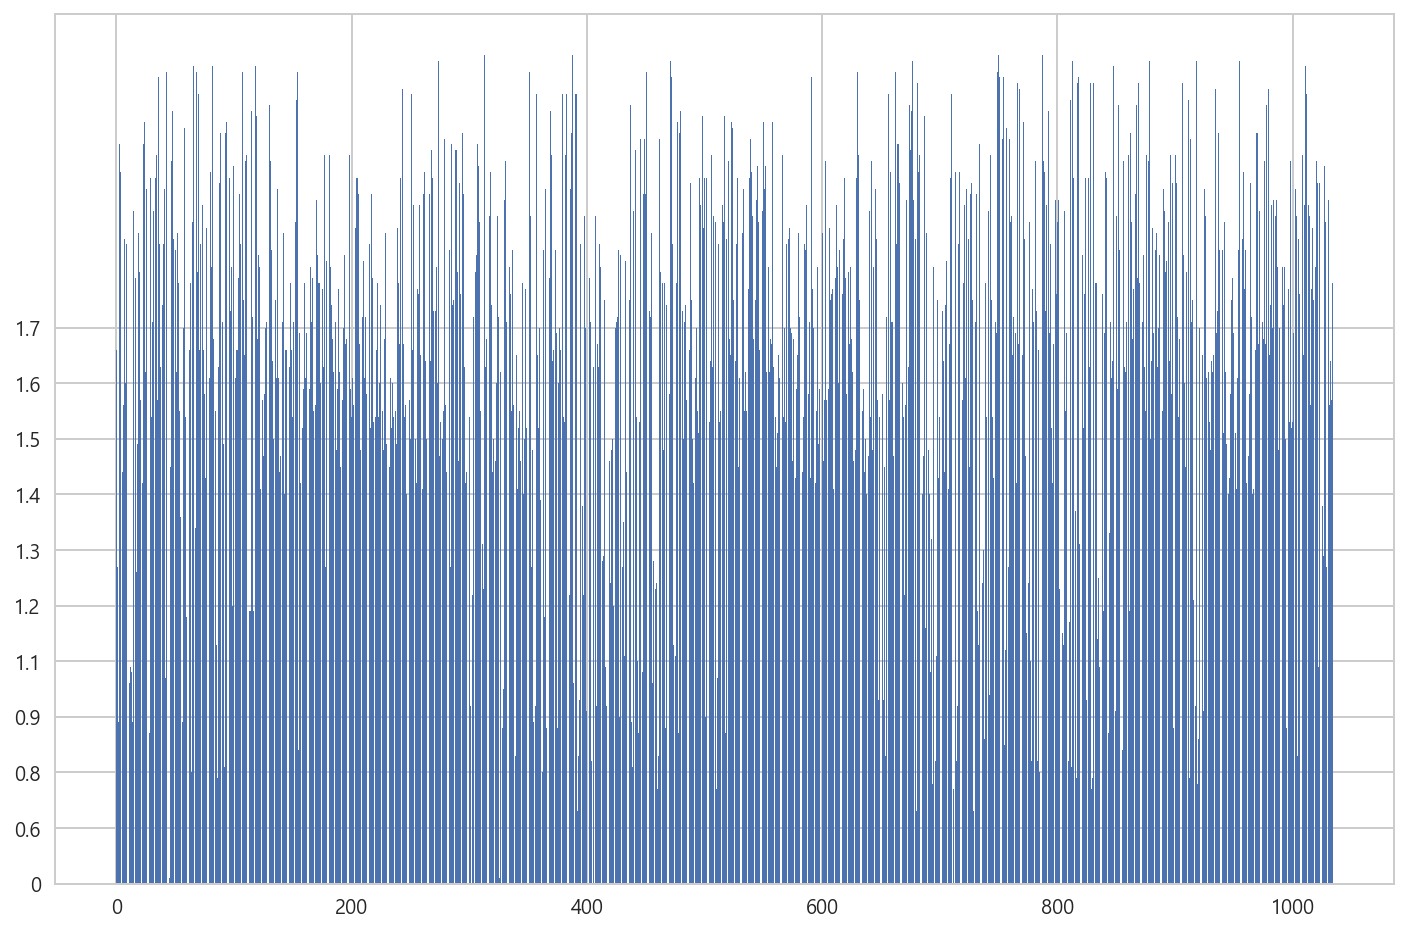

In [44]:
#barchart - 날짜별 날씨요소 변화

plt.figure(figsize=(12,8))
y1 = station_speed[1]
y2 = station_speed[18]
y3 = station_speed[20]
plt.bar(range(len(y1)),y1)
plt.yticks([0,10,20,30,40,50,60,70,80,90,100])
# plt.scatter([range(len(y1)),range(len(y2)),range(len(y3))],[y1,y2,y3],c=["b","g","r"])

plt.show()

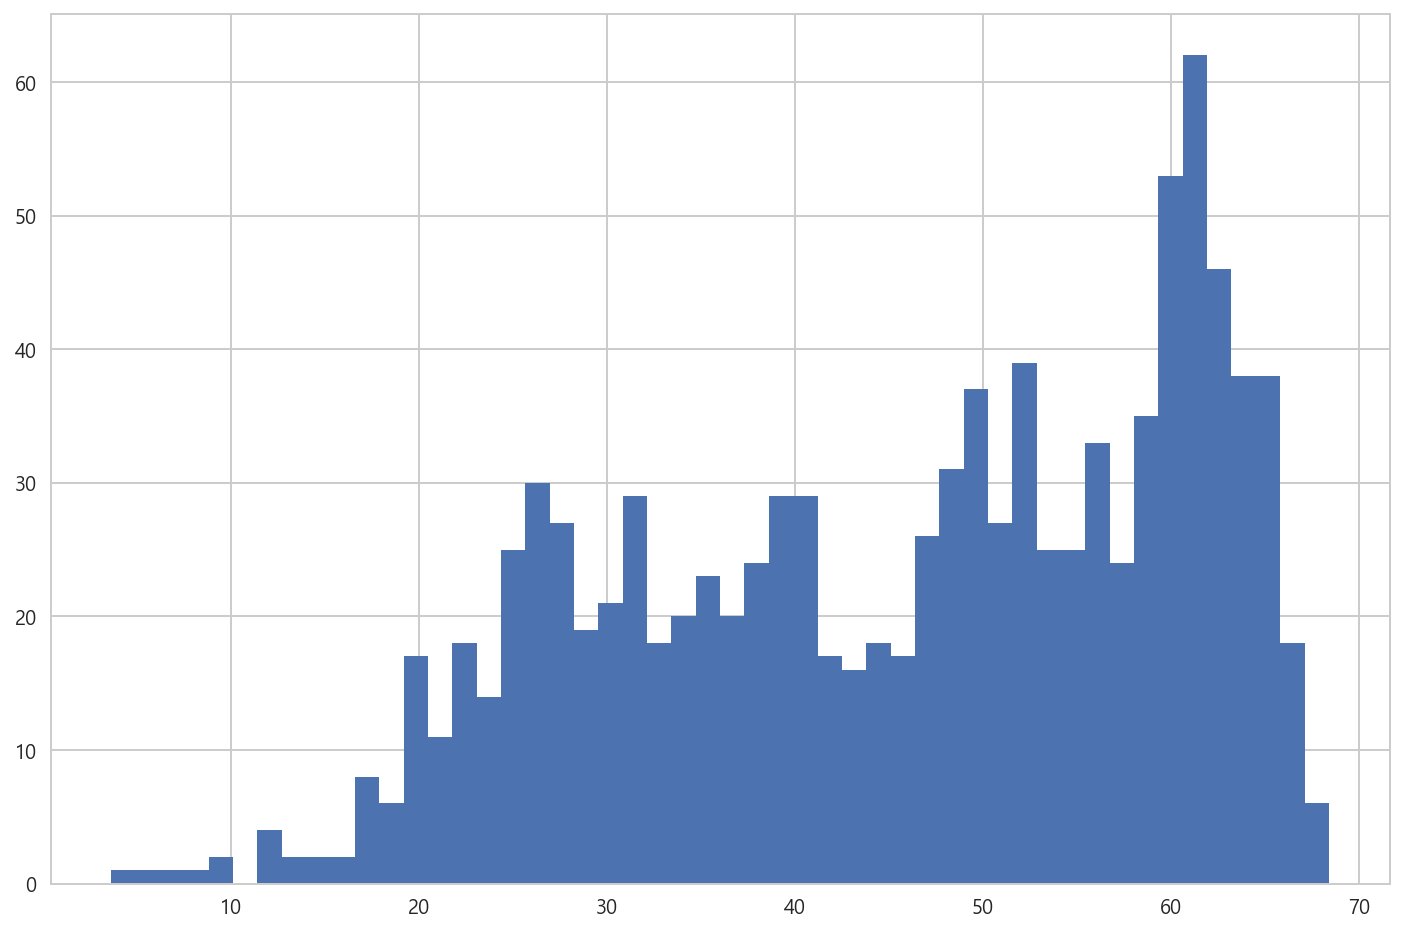

In [66]:
# histogram - 요소크기 분포도
plt.figure(figsize=(12,8))

Y = station_dewpoint_avg['dewpoint']

plt.hist(Y, bins = 50)
plt.show()

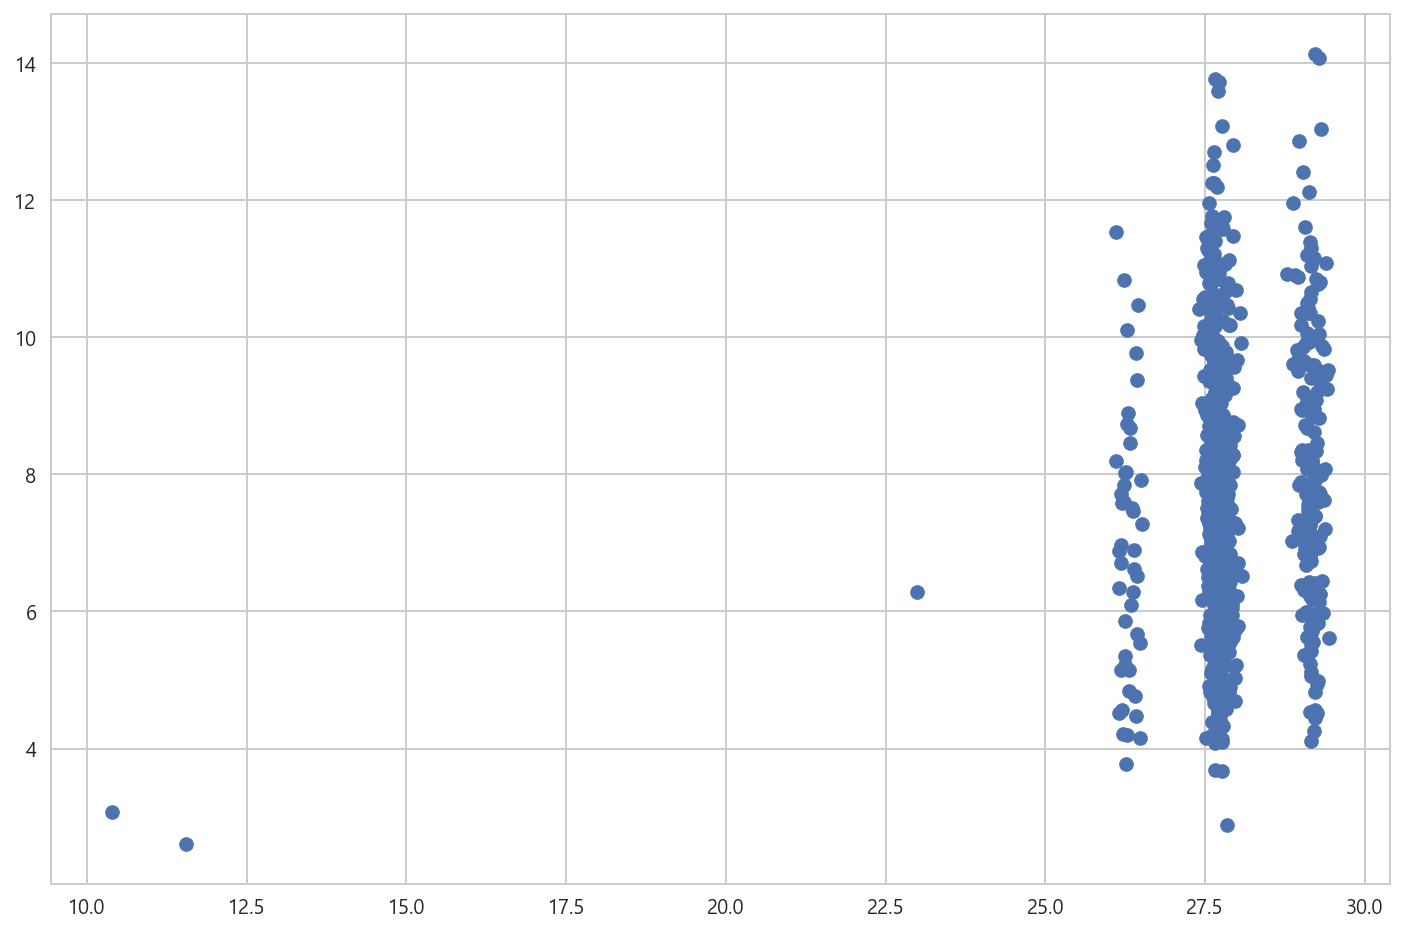

In [77]:
# scatter - 요소상관분포도

plt.figure(figsize=(12,8))

Y = station_speed_avg['avgspeed']
X = station_pressure_avg['stnpressure']
# plt.ylim(25,30)
plt.scatter(X,Y)

plt.show()



In [127]:
station_speed[1].values

array([  4.6,  10.3,  11.6, ...,   4.4,   3.7,   5.8])

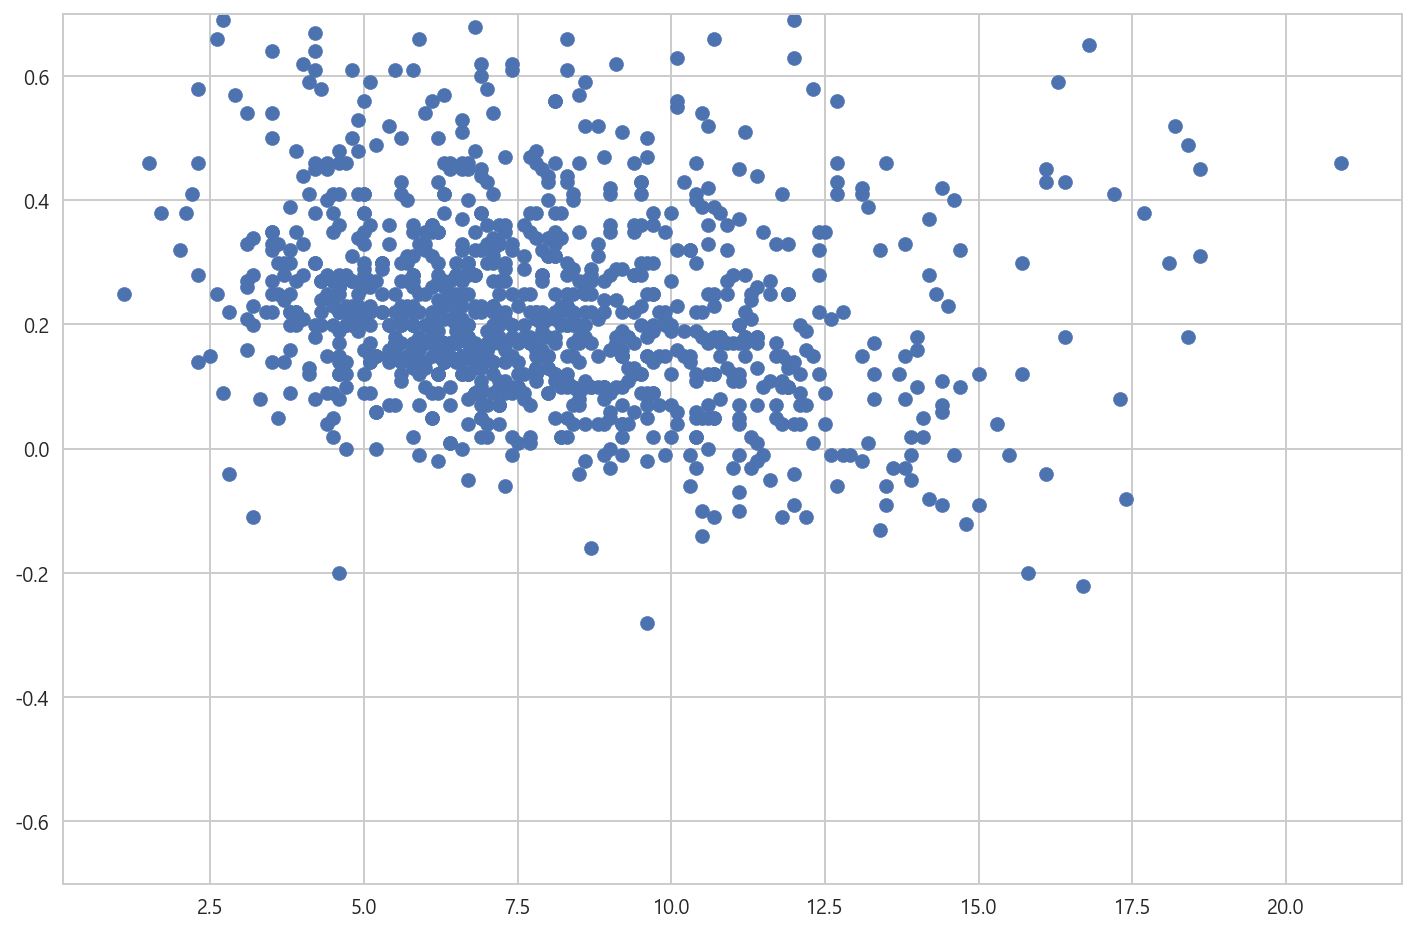

In [135]:
# scatter - station1의 기압 분산정도

plt.figure(figsize=(12,8))

Y = (station_pressure[20]-station_pressure_eachavg["stnpressure"][20]).values
X = station_speed[20].values

plt.ylim(-0.7,0.7)
plt.scatter(X,Y)

plt.show()



# 현재까지 알아낸 특성

1. 온도와 이슬점은 거의 매우 상관관계이다.
2. 온도와 바람세기는 거의 독립관계이다.
3. 스테이션별 기압은 고유의 범위를 가지고 있다. (고지대와 저지대의 차이로 볼수 있는듯)
4. 기압과 바람세기는 아주 미약한 반상관관계가 있다. (거의 상관이 없다)
5. 적설량은 있는곳만 있다(눈이 전혀 안오는 곳도 있다는 뜻)
6. 스테이션별로 3년간의 강우량 평균은 1에 일정한 분산을 가지는듯 보인다(아직 계산안해봄)

In [138]:
all_set.dtypes

date           datetime64[ns]
store_nbr               int64
station_nbr             int64
item_nbr                int64
units                   int64
tmax                   object
tmin                   object
tavg                    int64
depart                 object
dewpoint                int64
wetbulb                object
heat                   object
cool                   object
sunrise                object
sunset                 object
codesum                object
snowfall               object
preciptotal            object
stnpressure            object
sealevel               object
resultspeed            object
resultdir              object
avgspeed                int64
dtype: object

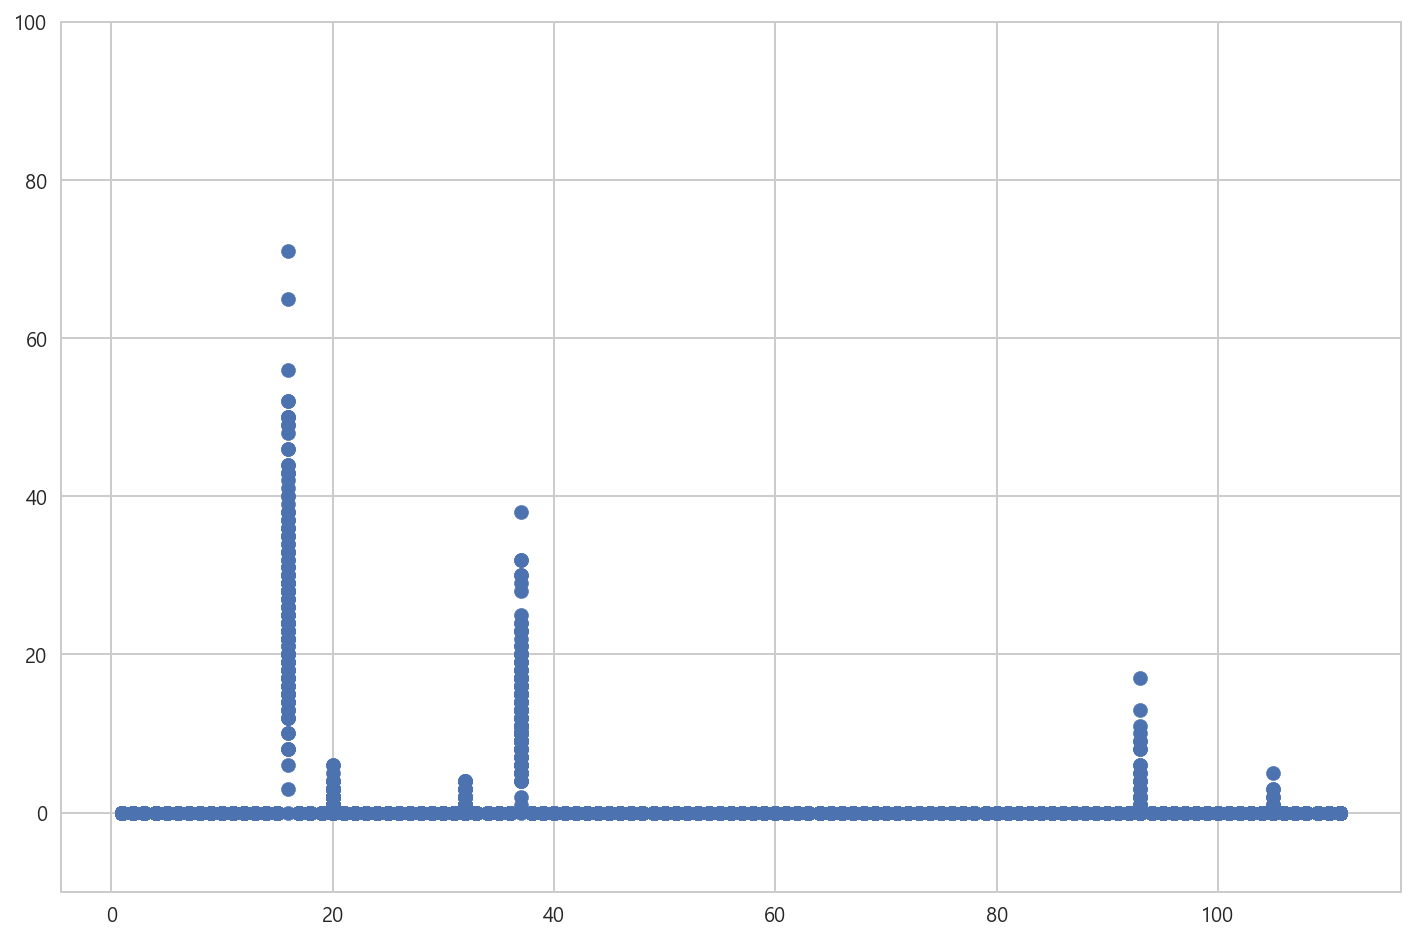

In [34]:
# 매장별 팔리는 아이템숫자 찍어보기

plt.figure(figsize=(12,8))

not0_items= all_set[all_set["store_nbr"] == 5]
not0_items= not0_items[not0_items["tavg"] <= 60]

X = not0_items["item_nbr"]

Y = not0_items["units"]

plt.ylim(-10,100)

plt.scatter(X,Y)

plt.show()
# store1_items

In [23]:
weather_df = pd.DataFrame(weather,columns=["tavg","avgspeed","dewpoint","stnpressure","sealevel","station_nbr","resultdir"])
# weather_df["date"]=weather_df["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
weather_df["avgspeed"] = pd.to_numeric(weather_df["avgspeed"], errors='coerce')
weather_df["tavg"] = pd.to_numeric(weather_df["tavg"], errors='coerce')
weather_df["dewpoint"] = pd.to_numeric(weather_df["dewpoint"], errors='coerce')
weather_df["stnpressure"] = pd.to_numeric(weather_df["stnpressure"], errors='coerce')
weather_df["sealevel"] = pd.to_numeric(weather_df["sealevel"], errors='coerce')
weather_df["resultdir"] = pd.to_numeric(weather_df["resultdir"], errors='coerce')

In [24]:
# 수집될 기상관측소 넘버 범위 지정
temp = weather_df[weather_df["station_nbr"]<20]
weather_df = temp[temp["station_nbr"]>=1]
weather_df["station_nbr"] = weather_df["station_nbr"].astype("str")

In [18]:
weather_df

,tavg,avgspeed,dewpoint,stnpressure,sealevel,station_nbr,resultdir
4,49.0,13.8,31.0,29.95,30.47,6,36.0
5,42.0,10.2,26.0,29.15,30.54,7,32.0
6,NaN,10.9,34.0,30.05,NaN,8,36.0
7,27.0,22.5,17.0,29.34,30.09,9,30.0
23,45.0,9.3,27.0,30.09,30.63,6,1.0
24,35.0,6.9,17.0,29.23,30.66,7,34.0
25,NaN,6.7,29.0,30.25,NaN,8,36.0
26,16.0,14.7,8.0,29.67,30.44,9,32.0
42,44.0,5.8,26.0,29.88,30.48,6,18.0
43,44.0,15.9,22.0,28.84,30.30,7,19.0


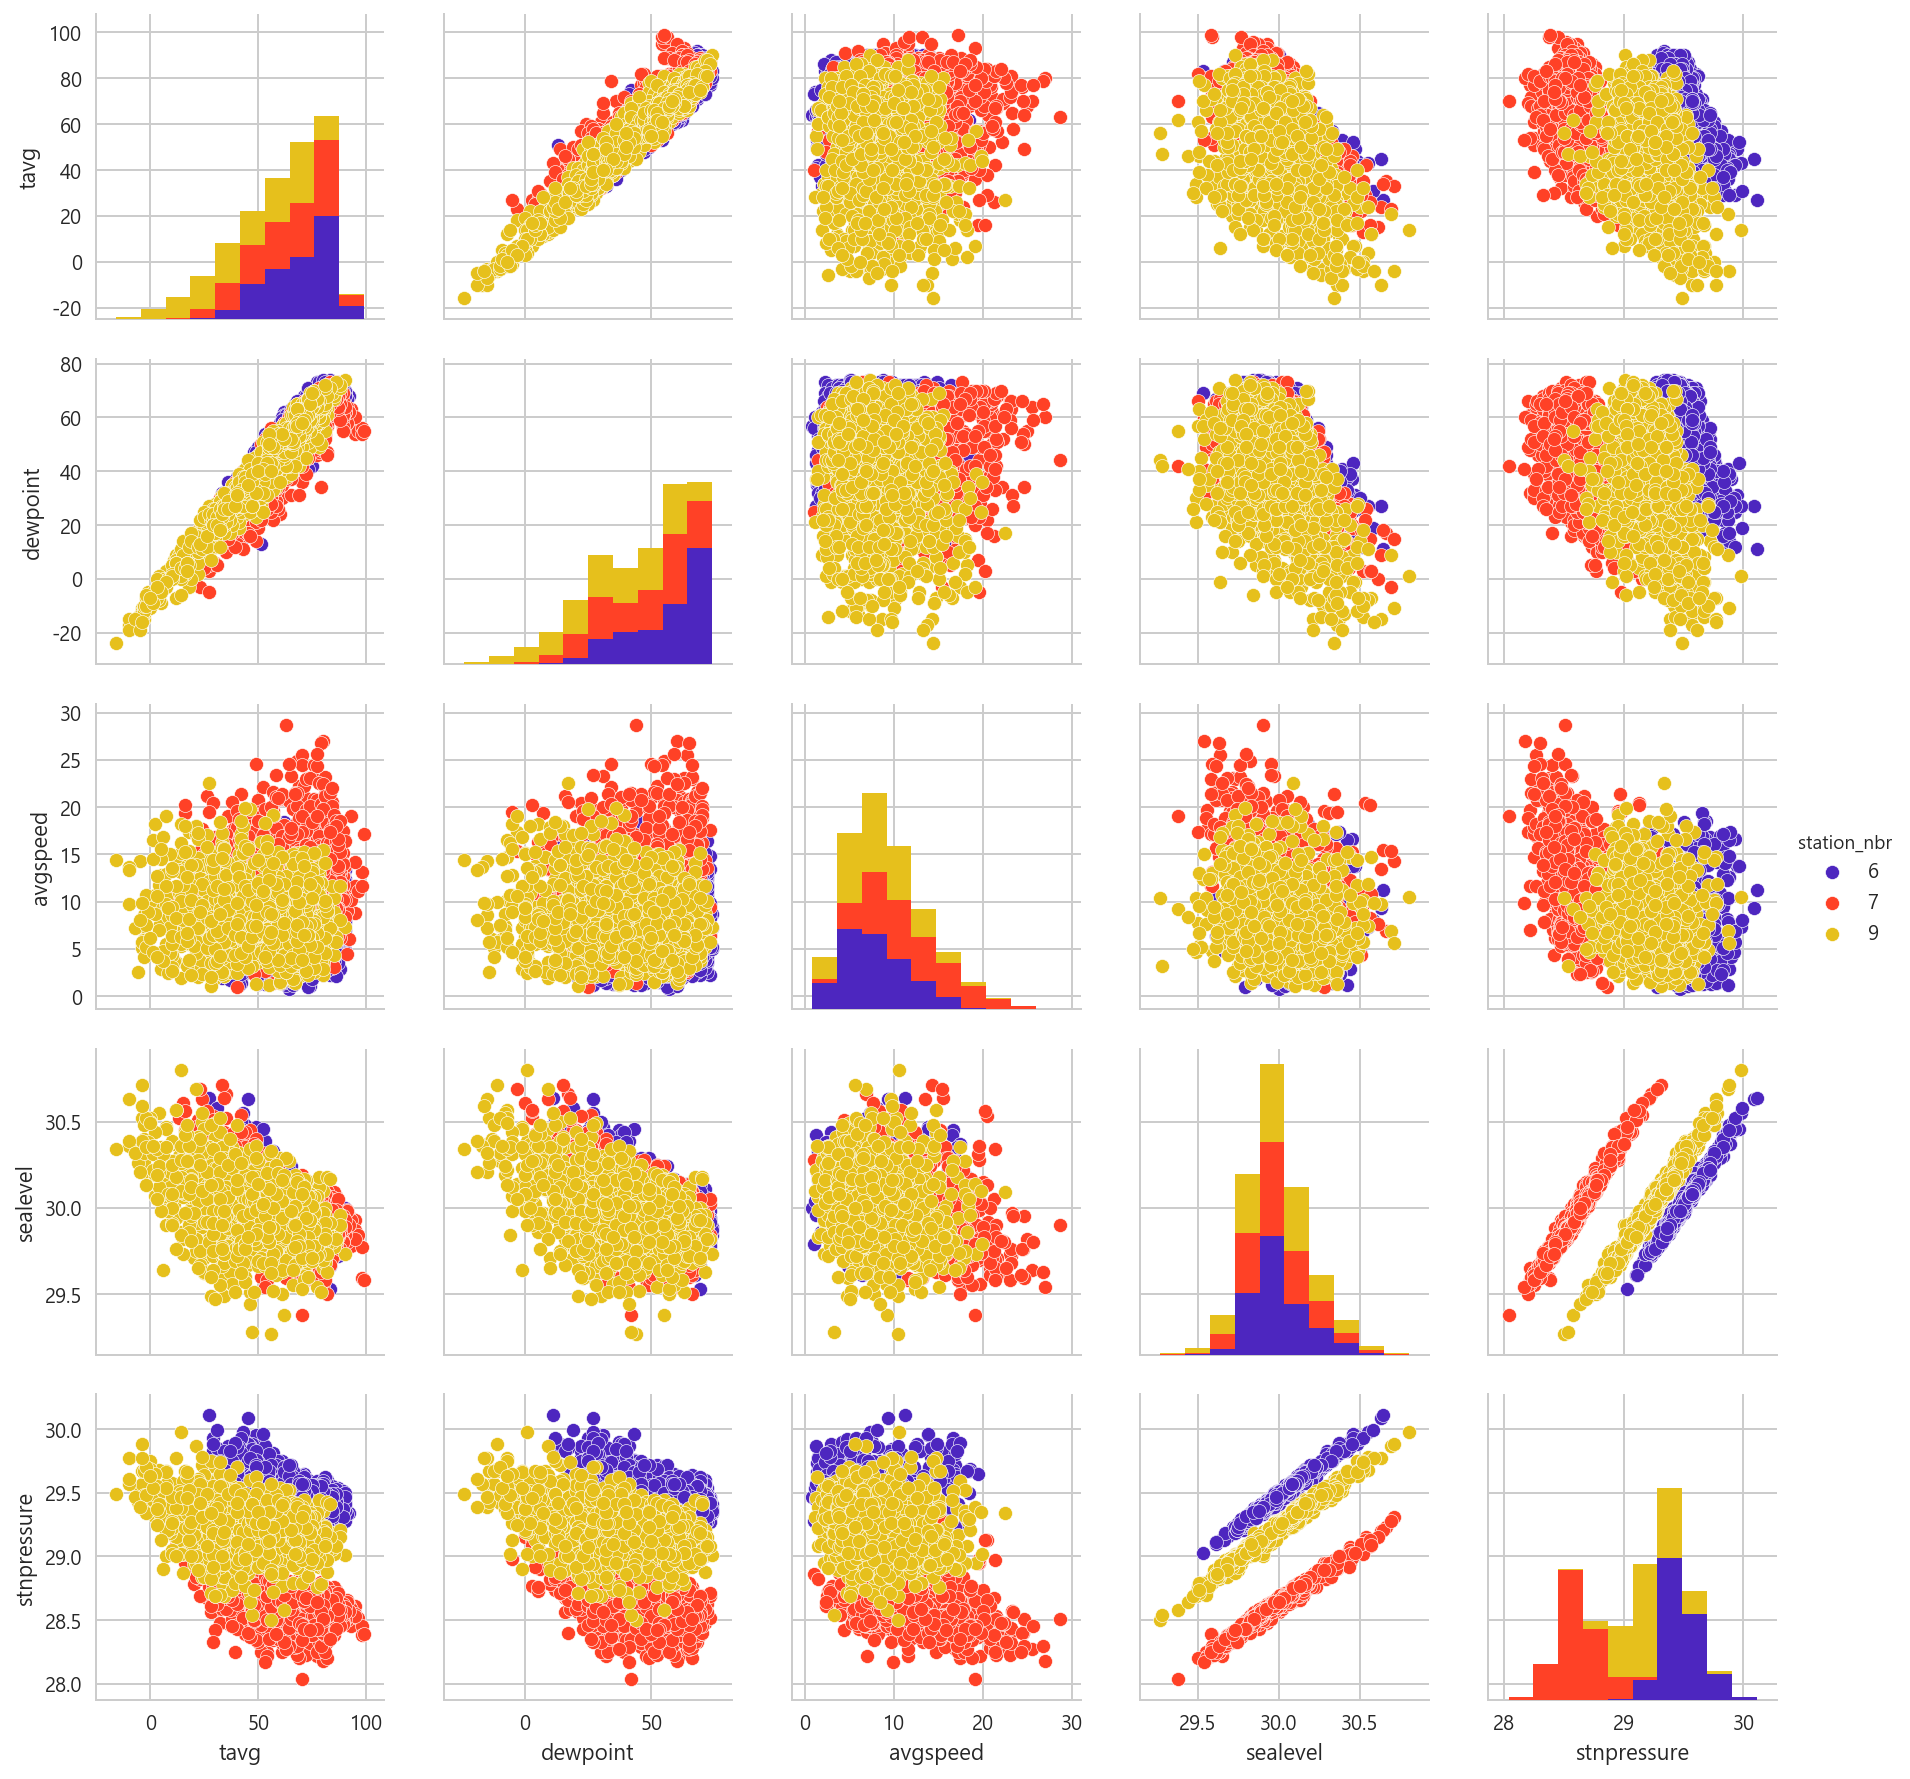

In [19]:
weather_df = weather_df.dropna() # NaN값이 존재하면 그래프 생성이 불가능함
sns.pairplot(weather_df, hue="station_nbr", vars=["tavg", "dewpoint", "avgspeed", "sealevel", "stnpressure"], palette="CMRmap")
plt.show()

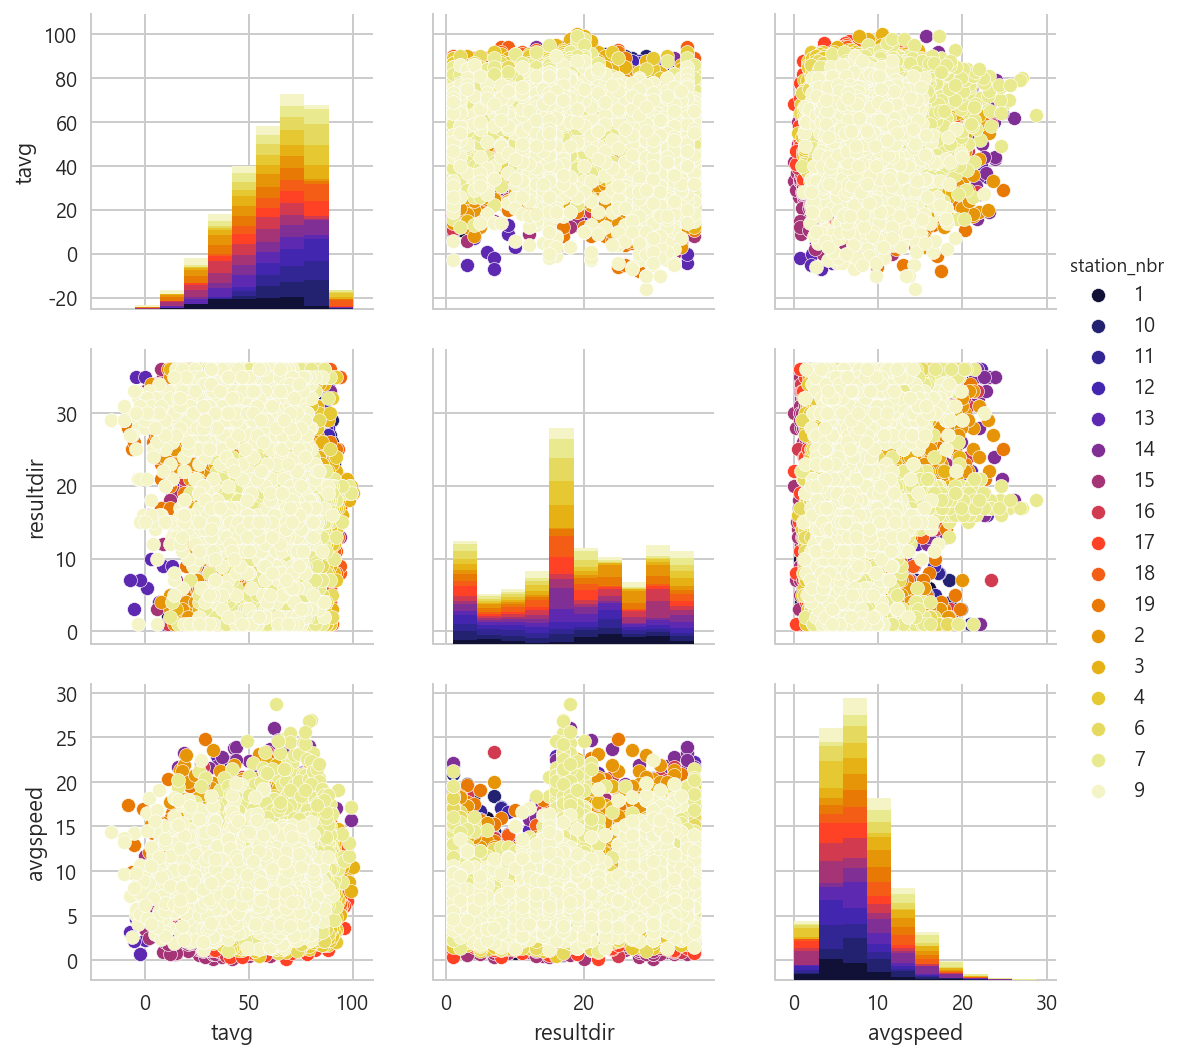

In [25]:
weather_df = weather_df.dropna() # NaN값이 존재하면 그래프 생성이 불가능함
sns.pairplot(weather_df, hue="station_nbr", vars=["tavg", "resultdir", "avgspeed"], palette="CMRmap")
plt.show()

> ### 위 그래프로부터 알수있는점
### 1. 온도와 이슬점온도는 비례상관관계이다
### 2. 온도가 80인 날이 많은편이다.
### 3. 바람은 5~15사이로 많이 분포한다
### 4. 기압의 경우 관측소별로 분포는 비슷하지만 기대값은 다르다.
### 5. 기압과 해수면의 높이는 미세한 반상관관계에 있다.
### 6. 해수면의 높이는 기댓값이 30이고 고르게 분포한다.
### 7. avgspeed는 result speed의 스칼라화 값에 가깝다. 즉 비교를 위해 바람방향을 지정해놓은 평균방향으로 크기를 지정했다는 의미이다.
### 8. depart, speed, (강우량, 적설량 T=0.05) 
### 9. 

In [70]:
# 스토어아이템의 데이터와 날씨 pairplot 비교
# 전처리
item_df = pd.DataFrame(all_set,columns=["item_nbr","units","tavg","avgspeed","dewpoint","stnpressure","sealevel","station_nbr"])
# weather_df["date"]=weather_df["date"].astype("datetime64[ns]") #-----열 선택하여 형변환
item_df["item_nbr"] = pd.to_numeric(item_df["item_nbr"], errors='coerce')
item_df["units"] = pd.to_numeric(item_df["units"], errors='coerce')
item_df["avgspeed"] = pd.to_numeric(item_df["avgspeed"], errors='coerce')
item_df["tavg"] = pd.to_numeric(item_df["tavg"], errors='coerce')
item_df["dewpoint"] = pd.to_numeric(item_df["dewpoint"], errors='coerce')
item_df["stnpressure"] = pd.to_numeric(item_df["stnpressure"], errors='coerce')
item_df["sealevel"] = pd.to_numeric(item_df["sealevel"], errors='coerce')


In [71]:
# 수집할 아이템의 넘버 범위지정 및 units=0 조건 제거
item_df = item_df[item_df["units"] != 0]
temp = item_df[item_df["item_nbr"]<10]
item_df = temp[temp["item_nbr"]>=9]
item_df["item_nbr"] = item_df["item_nbr"].astype("str")

C:\Users\creal\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


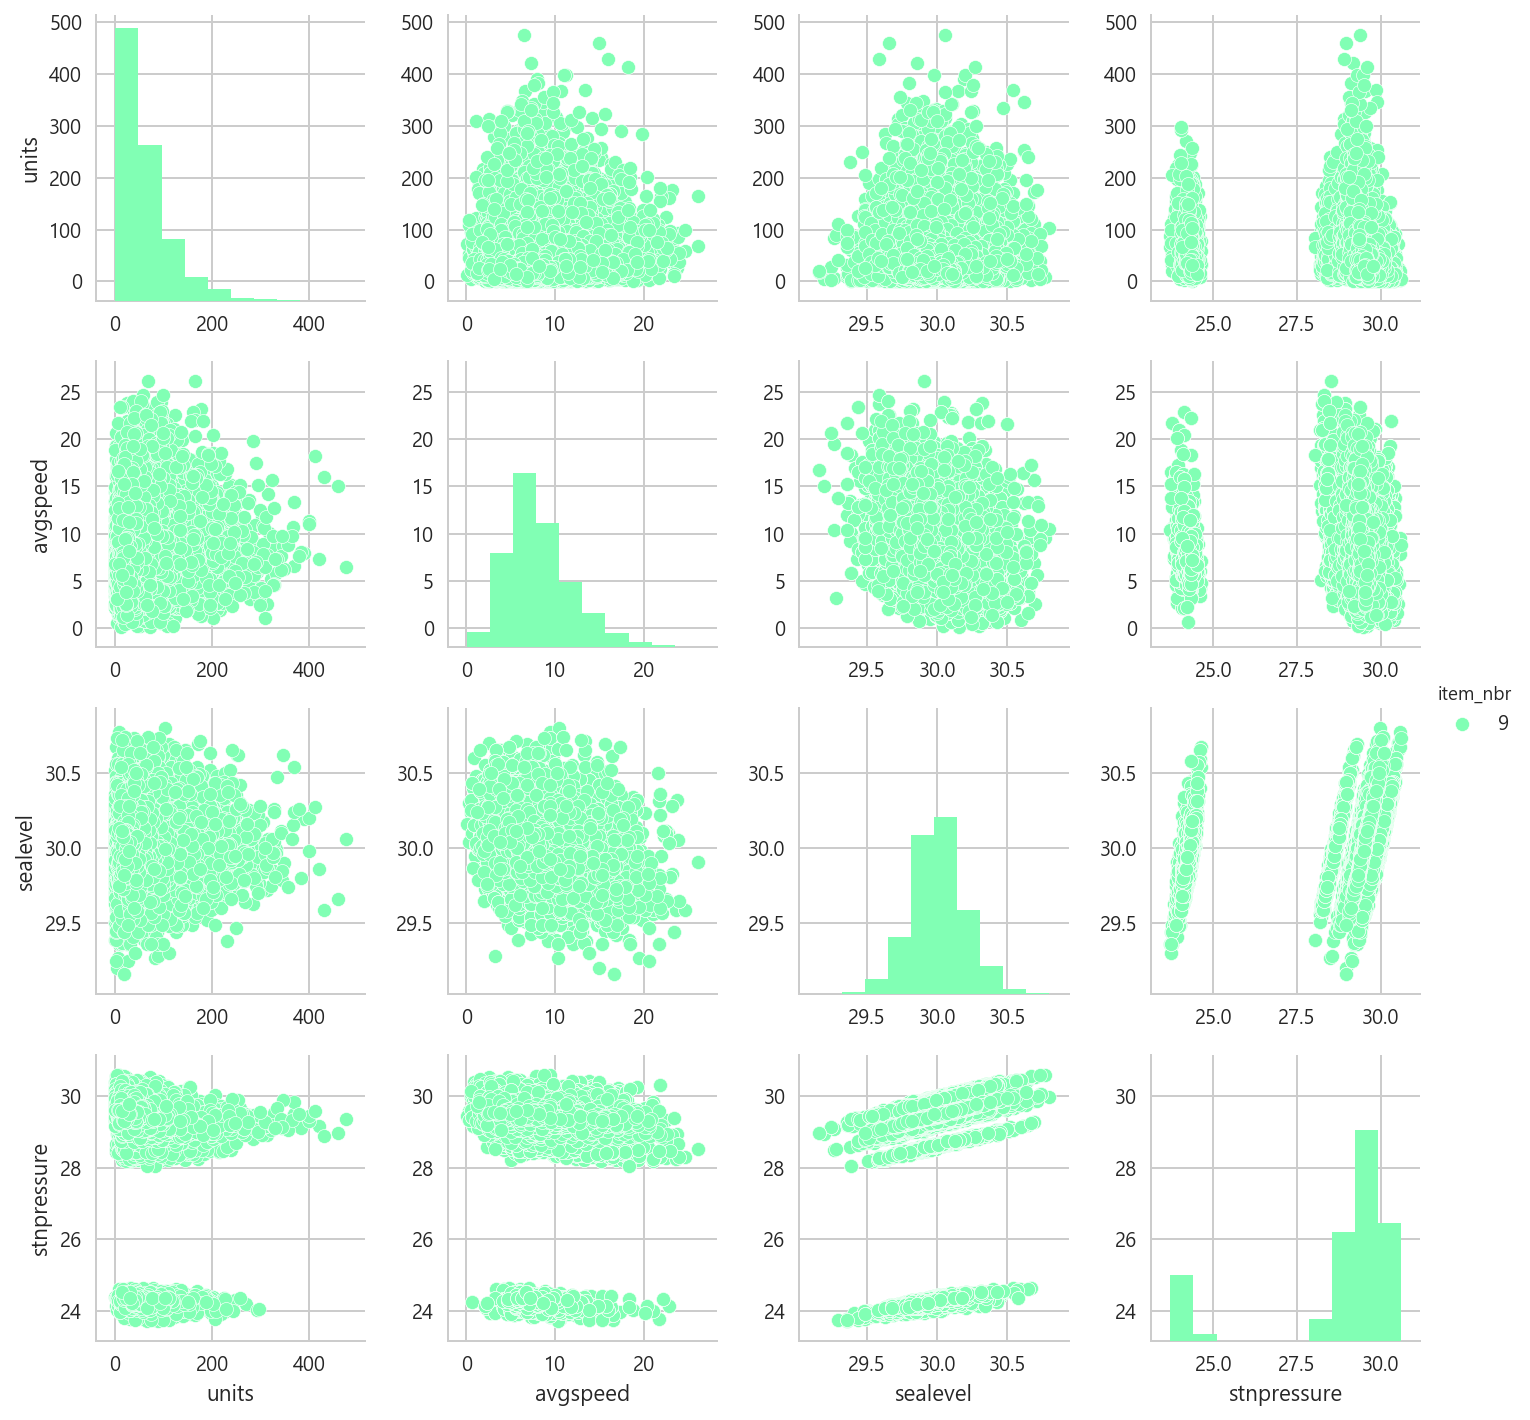

In [73]:
item_df = item_df.dropna() # NaN값이 존재하면 그래프 생성이 불가능함
sns.pairplot(item_df, hue="item_nbr", vars=["units", "avgspeed", "sealevel", "stnpressure"], palette="rainbow")
plt.show()

In [ ]:
# pdp.ProfileReport(all_set) #모든객체들 비교